# SCENARIO 

In SY 20-21, TEA required all Texas LEAs (Local Education Agencies such as a school district) to administer either the TX-KEA or mCLASS assessment to Kindergarten students in order to measure Kindergarten readiness. The Tx-KEA and mCLASS diagnostics employ different scales for scoring and evaluate different sets of skills. Initial analysis of Fall 2020 data indicates a 38 percentage point gap in Kindergarten readiness between the two tests; 76% of students who took Tx-KEA were found to be Kindergarten ready compared to just 38% of students who took mCLASS. 

Your task is to extract, analyze, and present data that will help the Early Childhood Education team understand to what extent the difference in readiness as measured by the tests is due to differences in the underlying populations of students taking each (as opposed to differences in test design and scoring). As mentioned above, your response should include the following three components:

1)A SQL query you have written to aggregate and extract necessary data from the database,
2)A data cleaning/analysis script,
3)A brief narrative which describes key findings and includes data visualizations

Please limit the analysis to students taking the English version of each diagnostic to avoid complications that arise from differences in the English and Spanish versions of mCLASS.

Component 1:

Below is a description of the database and an entity relationship diagram to help you prepare a SQL query that leverages the database to both extract and aggregate relevant data to prepare for analysis. Your analysis script should take as inputs the attached three data files (currently in csv format) which mimic the tables in the described database. Database Tables:

1)MCLASS – student level performance on mCLASS diagnostic assessment.
•Field ‘assessment_edition’ indicates whether the student took the English version of thetest (DIBELS) or the Spanish version (IDEL).
•For field ‘composite_level’ values of ‘At Benchmark’ or ‘Above Benchmark’ indicatesKindergarten readiness.

2)TXKEA – student level performance on Tx-KEA diagnostic assessment.
•Field ‘language’ indicates whether the student took the English or Spanish version
•For field ‘lit_screening_benchmark’ value of ‘On-Track’ indicates Kindergarten readiness.

3)DEMO – student level demographic data.
•Field ‘eco’ indicates whether the student is identified as ‘economically disadvantaged’
•Field ‘spec_ed’ indicates whether the student receives special education services
•Field ‘el’ indicates whether the student is identified as an English learner

Component 2:
Demonstrate how you prepared and analyzed the data in response to the scenario. For the data analysis script, Python is the preferred language but not a requirement. The script can be written in the programming language of your choice. Depending on your SQL query (because the database in component 1 is hypothetical), the first part of your data cleaning/analysis script may need to replicate some portion of the initial manipulation your SQL query accomplishes. 

Component 3: Please combine the narrative analysis and visualization in one file. Though Power BI is the preferred visualization software, the data presentation can be done using any software you choose (e.g. Tableau, Looker, Jupyter notebook, etc.).

In [521]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from statsmodels.graphics.mosaicplot import mosaic

The first thing I want to do is take a look at the shape of the data files so I can better decide how I should choose which join to perform.

In [522]:
demo = pd.read_csv('Data/DEMO.csv')
demo.head()

C:\Users\tomsh\anaconda3\envs\my_env\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,student_id,district_id,ethnicity,eco,el,spec_ed
0,97840593,798403,Black or African American,YES,NO,NO
1,885938600,53405,White,YES,NO,NO
2,871944576,798403,Black or African American,YES,NO,NO
3,818725252,53405,White,NO,NO,NO
4,702015143,800409,White,YES,NO,YES


In [523]:
demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174348 entries, 0 to 174347
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   student_id   174348 non-null  object
 1   district_id  174348 non-null  int64 
 2   ethnicity    174348 non-null  object
 3   eco          174348 non-null  object
 4   el           174348 non-null  object
 5   spec_ed      174348 non-null  object
dtypes: int64(1), object(5)
memory usage: 8.0+ MB


In [524]:
mclass = pd.read_csv('Data/MCLASS.csv')
mclass.head()

,student_id,district_id,school_id,assessment_edition,composite_level,composite_score
0,8878547139,806405.0,806405802,DIBELS 8th Edition,At Benchmark,306.0
1,8878132753,818408.0,818408807,DIBELS 8th Edition,Below Benchmark,291.0
2,8877357966,NaN,NaN,DIBELS 8th Edition,At Benchmark,314.0
3,8877359986,820405.0,820405805,DIBELS 8th Edition,At Benchmark,326.0
4,8877961413,820407.0,820407871,DIBELS 8th Edition,At Benchmark,308.0


In [525]:
mclass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63268 entries, 0 to 63267
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   student_id          63268 non-null  int64  
 1   district_id         57028 non-null  float64
 2   school_id           56676 non-null  object 
 3   assessment_edition  63268 non-null  object 
 4   composite_level     63268 non-null  object 
 5   composite_score     56124 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 2.9+ MB


In [526]:
txkea = pd.read_csv('Data/TXKEA.csv')
txkea.head()

,district_id,student_id,language,lit_screening_benchmark,lit_screening_score,date
0,70408,8878861576,English,Monitor,15,9/15/2020
1,808486,8878825752,English,On-Track,29,11/30/2020
2,801404,8878799239,English,Support,14,10/12/2020
3,808488,8878794629,English,On-Track,35,11/6/2020
4,808486,8878745384,English,On-Track,23,10/16/2020


In [527]:
txkea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112048 entries, 0 to 112047
Data columns (total 6 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   district_id              112048 non-null  int64 
 1   student_id               112048 non-null  int64 
 2   language                 112048 non-null  object
 3   lit_screening_benchmark  112048 non-null  object
 4   lit_screening_score      112048 non-null  int64 
 5   date                     112048 non-null  object
dtypes: int64(3), object(3)
memory usage: 5.1+ MB


After a cursory look at the data, the DEMO dataframe has the most rows and no null values so I will join the other two onto it merging the student_id columns.

In [528]:
merged =demo.merge(txkea[['language', 'lit_screening_benchmark', 'student_id']], on='student_id', how='left')

In [529]:
df = merged.merge(mclass[['student_id', 'assessment_edition', 'composite_level']], on='student_id', how='left')

In [530]:
df.head()

,student_id,district_id,ethnicity,eco,el,spec_ed,language,lit_screening_benchmark,assessment_edition,composite_level
0,97840593,798403,Black or African American,YES,NO,NO,NaN,NaN,NaN,NaN
1,885938600,53405,White,YES,NO,NO,English,On-Track,NaN,NaN
2,871944576,798403,Black or African American,YES,NO,NO,English,On-Track,NaN,NaN
3,818725252,53405,White,NO,NO,NO,English,On-Track,NaN,NaN
4,702015143,800409,White,YES,NO,YES,English,On-Track,NaN,NaN


In [531]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175683 entries, 0 to 175682
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   student_id               175683 non-null  object
 1   district_id              175683 non-null  int64 
 2   ethnicity                175683 non-null  object
 3   eco                      175683 non-null  object
 4   el                       175683 non-null  object
 5   spec_ed                  175683 non-null  object
 6   language                 84237 non-null   object
 7   lit_screening_benchmark  84237 non-null   object
 8   assessment_edition       47600 non-null   object
 9   composite_level          47600 non-null   object
dtypes: int64(1), object(9)
memory usage: 14.7+ MB


# Number Of Missing Values By Column

There are many NaN values. Let's count the number of missing values in each column and sort them.

In [532]:

missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count')

,count,%
student_id,0,0.000000
district_id,0,0.000000
ethnicity,0,0.000000
eco,0,0.000000
el,0,0.000000
spec_ed,0,0.000000
language,91446,52.051707
lit_screening_benchmark,91446,52.051707
assessment_edition,128083,72.905745
composite_level,128083,72.905745


As i suspected there are a lot of NaN values in lit_screening_benchmark and composite_level columns. We are trying to make sense of the data based on these scores so if there is no score in either it can be removed from the dataframe.

In [533]:
df = df.dropna(subset=['lit_screening_benchmark','composite_level'], how='all')

# Component 1 - Drop Spanish language versions of the test

We must limit the analysis to students taking the English version of each diagnostic to avoid complications that arise from differences in the English and Spanish versions of mCLASS.

In [534]:
#checking values
df.assessment_edition.value_counts()

DIBELS 8th Edition        42182
IDEL Standard 3 Period     5418
Name: assessment_edition, dtype: int64

In [535]:
df.language.value_counts()

English    71032
Spanish    13205
Name: language, dtype: int64

In [536]:
#droping Spanish versions
df.drop(df.loc[df['assessment_edition']=='IDEL Standard 3 Period'].index,inplace=True)

In [537]:
df.assessment_edition.value_counts()

DIBELS 8th Edition    42182
Name: assessment_edition, dtype: int64

In [538]:
df.drop(df.loc[df['language']=='Spanish'].index,inplace=True)

In [539]:
df.language.value_counts()

English    71026
Name: language, dtype: int64

In [540]:
df.drop(['language', 'assessment_edition'],axis=1,inplace=True)


In [541]:
df.head()

,student_id,district_id,ethnicity,eco,el,spec_ed,lit_screening_benchmark,composite_level
1,885938600,53405,White,YES,NO,NO,On-Track,NaN
2,871944576,798403,Black or African American,YES,NO,NO,On-Track,NaN
3,818725252,53405,White,NO,NO,NO,On-Track,NaN
4,702015143,800409,White,YES,NO,YES,On-Track,NaN
5,717968813,48403,Two or more races,YES,NO,NO,On-Track,NaN


# Ensure that no rows have values for both MCLASS and TXKEA assessments

In [542]:
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count')

,count,%
student_id,0,0.000000
district_id,0,0.000000
ethnicity,0,0.000000
eco,0,0.000000
el,0,0.000000
spec_ed,0,0.000000
lit_screening_benchmark,41852,37.077198
composite_level,70701,62.634880


In [543]:
df.shape

(112878, 8)

41852 + 70701 does not equal 112878 so it looks like we have students who have taken both assessments. Let's make sure.

In [544]:
both = df[df[['lit_screening_benchmark', 'composite_level']].notnull().all(1)]
both.count()

student_id                 325
district_id                325
ethnicity                  325
eco                        325
el                         325
spec_ed                    325
lit_screening_benchmark    325
composite_level            325
dtype: int64

So 325 students have taken both versions of the test. We can also see conflicting results. This is a small sample but could be useful later when comparing the two assessments.

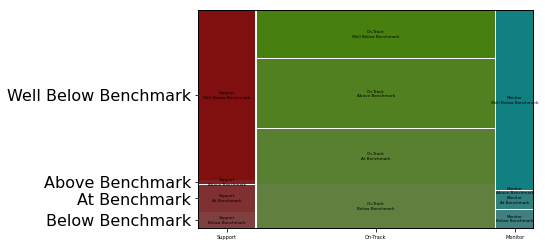

In [545]:
mosaic(data=both, index=['lit_screening_benchmark', 'composite_level'])
plt.rc('font', size=5)
plt.show()

# Assessment Scoring

Let's take a quick look at each assessments outcome.

<AxesSubplot:>

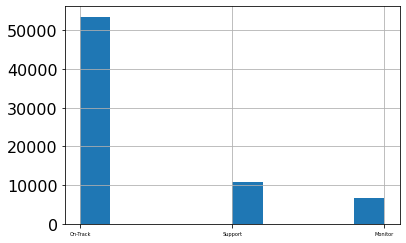

In [546]:
df.lit_screening_benchmark.hist()


<AxesSubplot:>

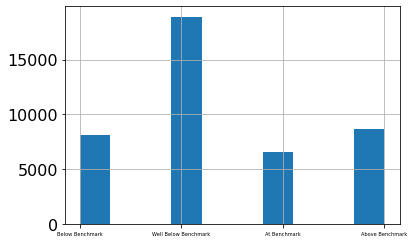

In [547]:
df.composite_level.hist()

There is a very big difference in the outcomes of either test as is indicated in the instructions.

# Split the dataframes into their own copies 

It will be easier to examine relationships by redividing dataframes as well as encoding the assessment outcomes.

### MCLASS Aseessment

In [548]:
le = preprocessing.LabelEncoder()

In [549]:
df['composite_level_code']= le.fit_transform(df['composite_level'])

In [550]:
test=df[['composite_level', 'composite_level_code']]


### Composite_level_code Legend:
Above Benchmark = 0
At Benchmark = 1
Below Benchmark = 2
Well Below Benchmark = 3


This scale means that the lower the score, the better that population did on the assessment

In [552]:
df_composite_level_test = df[df.composite_level_code != 4]

<AxesSubplot:xlabel='ethnicity'>

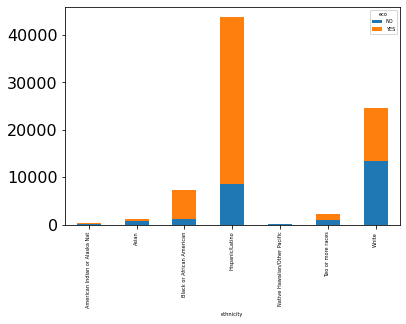

In [555]:
(df_composite_level_test.pivot_table(index='ethnicity', columns='eco', values='composite_level_code',
                aggfunc='sum')
   .plot.bar(stacked=True)
)


<AxesSubplot:xlabel='ethnicity'>

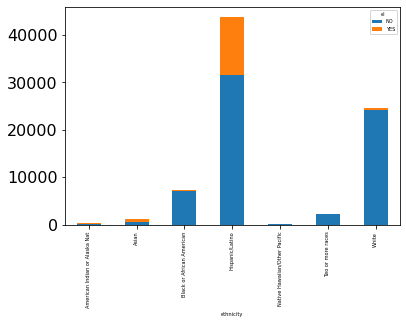

In [556]:
(df_composite_level_test.pivot_table(index='ethnicity', columns='el', values='composite_level_code',
                aggfunc='sum')
   .plot.bar(stacked=True)
)


<AxesSubplot:xlabel='ethnicity'>

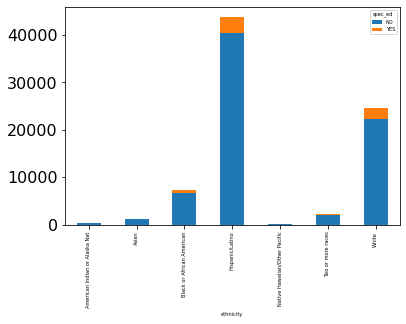

In [557]:
(df_composite_level_test.pivot_table(index='ethnicity', columns='spec_ed', values='composite_level_code',
                aggfunc='sum')
   .plot.bar(stacked=True)
)

# Comparing columns

Perhaps it would be more useful to examine these two outcomes based on the information found in the DEMO file.

In [559]:
df.groupby(['composite_level','ethnicity']).size()

composite_level       ethnicity                    
Above Benchmark       American Indian or Alaska Nat       24
                      Asian                              916
                      Black or African American          826
                      Hispanic/Latino                   2497
                      Native Hawaiian/Other Pacific       20
                      Two or more races                  393
                      White                             3944
At Benchmark          American Indian or Alaska Nat       13
                      Asian                              258
                      Black or African American          656
                      Hispanic/Latino                   2542
                      Native Hawaiian/Other Pacific       15
                      Two or more races                  280
                      White                             2785
Below Benchmark       American Indian or Alaska Nat       24
                      Asian      

In [563]:
df.groupby(['lit_screening_benchmark', 'ethnicity']).size()

lit_screening_benchmark  ethnicity                    
Monitor                  American Indian or Alaska Nat       15
                         Asian                              109
                         Black or African American          999
                         Hispanic/Latino                   3500
                         Native Hawaiian/Other Pacific        7
                         Two or more races                  228
                         White                             1817
On-Track                 American Indian or Alaska Nat      150
                         Asian                             2746
                         Black or African American         7494
                         Hispanic/Latino                  21547
                         Native Hawaiian/Other Pacific       48
                         Two or more races                 2282
                         White                            19276
Support                  American Indian or Alask

In [564]:
df.groupby(['composite_level','eco']).size()

composite_level       eco
Above Benchmark       NO      5548
                      YES     3072
At Benchmark          NO      3305
                      YES     3244
Below Benchmark       NO      3265
                      YES     4833
Well Below Benchmark  NO      5009
                      YES    13901
dtype: int64

In [565]:
df.groupby(['lit_screening_benchmark', 'eco']).size()

lit_screening_benchmark  eco
Monitor                  NO      1850
                         YES     4825
On-Track                 NO     24910
                         YES    28633
Support                  NO      2134
                         YES     8674
dtype: int64

In [566]:
df.groupby(['composite_level','el']).size()

composite_level       el 
Above Benchmark       NO      7935
                      YES      685
At Benchmark          NO      5999
                      YES      550
Below Benchmark       NO      7180
                      YES      918
Well Below Benchmark  NO     15190
                      YES     3720
dtype: int64

In [567]:
df.groupby(['lit_screening_benchmark', 'el']).size()

lit_screening_benchmark  el 
Monitor                  NO      5829
                         YES      846
On-Track                 NO     48307
                         YES     5236
Support                  NO      8030
                         YES     2778
dtype: int64

In [568]:
df.groupby(['composite_level','spec_ed']).size()

composite_level       spec_ed
Above Benchmark       NO          8240
                      YES          380
At Benchmark          NO          6134
                      YES          415
Below Benchmark       NO          7486
                      YES          612
Well Below Benchmark  NO         17290
                      YES         1620
dtype: int64

In [569]:
df.groupby(['lit_screening_benchmark', 'spec_ed']).size()

lit_screening_benchmark  spec_ed
Monitor                  NO          6032
                         YES          643
On-Track                 NO         50243
                         YES         3300
Support                  NO          9360
                         YES         1448
dtype: int64